In [14]:
import os
import cv2
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv

In [ ]:
def loadImages(dir):
    filenames = os.listdir(dir)
    sorted_filenames = sorted(filenames, key=lambda x: int(x.split('.')[0]))

    images = []
    for filename in sorted_filenames:
        img = cv2.imread(os.path.join(dir,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

In [ ]:
images = loadImages("../../test/dataset")

In [ ]:
plt.imshow(images[1])

In [15]:
def rgb_to_hsv(img):
    img = img / 255.0

    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    cmax = np.max(img, axis=2); cmin = np.min(img, axis=2)
    delta = cmax - cmin
    h = np.zeros_like(cmax); s = np.zeros_like(cmax)
    v = cmax

    with np.errstate(invalid='ignore'):
        h[(delta != 0) & (cmax == r)] = 60 * (((g - b) / delta) % 6)[((delta != 0) & (cmax == r))]
        h[(delta != 0) & (cmax == g)] = 60 * ((b - r) / delta + 2)[((delta != 0) & (cmax == g))]
        h[(delta != 0) & (cmax == b)] = 60 * ((r - g) / delta + 4)[((delta != 0) & (cmax == b))]

    s[cmax != 0] = delta[cmax != 0] / cmax[cmax != 0]

    return np.dstack((h, s, v))

In [16]:
def hsv_quantify(img):
    h, s, v = img[:, :, 0], img[:, :, 1], img[:, :, 2]

    def map_h(h):
        if h <= 25:
            return 1
        elif h <= 40:
            return 2
        elif h <= 120:
            return 3
        elif h <= 190:
            return 4
        elif h <= 270:
            return 5
        elif h <= 295:
            return 6
        elif h <= 315:
            return 7
        else:
            return 0

    def map_sv(value):
        if value < 0.2:
            return 0
        elif value < 0.7:
            return 1
        else:
            return 2

    mapped_h = np.vectorize(map_h)(h)
    mapped_s = np.vectorize(map_sv)(s)
    mapped_v = np.vectorize(map_sv)(v)

    return np.dstack((mapped_h, mapped_s, mapped_v))

In [40]:
def split_image(img):
    block_size_x = img.shape[0] // 4
    block_size_y = img.shape[1] // 4

    blocks = []

    for i in range(4):
        for j in range(4):
            # remaining pixels for the last block
            if i == 3:  # Last row
                block_x = img.shape[0] - i * block_size_x
            else:
                block_x = block_size_x
            
            if j == 3:
                block_y = img.shape[1] - j * block_size_y
            else:
                block_y = block_size_y

            block = img[i * block_size_x: i * block_size_x + block_x, j * block_size_y: j * block_size_y + block_y, :]
            blocks.append(block)

    return blocks


In [18]:
def build_vector(img):
    num_h_levels = 8
    num_sv_levels = 3

    block_frequency_vectors = []

    for block in img:
        flattened_block = block.reshape((-1, 3))

        block_frequency_vector = np.zeros((num_h_levels * num_sv_levels * num_sv_levels,), dtype=int)

        for pixel in flattened_block:
            h_index = int(pixel[0])
            s_index = int(pixel[1])
            v_index = int(pixel[2])

            index = h_index * (num_sv_levels * num_sv_levels) + s_index * num_sv_levels + v_index
            block_frequency_vector[index] += 1

        block_frequency_vectors.append(block_frequency_vector)

    block_frequency_vectors_array = np.array(block_frequency_vectors)
    return block_frequency_vectors_array


In [19]:
def cosine_similarity_color(A, B):
    A = A.astype(np.int64)
    B = B.astype(np.int64)
    cosine = 0

    for i in range(A.shape[0]):
        if (i == 5 or i == 6 or i == 9 or i == 10):
            cosine += (1.25*(np.dot(A[i],B[i]) / (norm(A[i])*norm(B[i]))))
        else:
            cosine += (np.dot(A[i],B[i]) / (norm(A[i])*norm(B[i])))

        # cosine += (np.dot(A[i],B[i]) / (norm(A[i])*norm(B[i])))

    percent = ((1 + (cosine / 17))/2) * 100
    return percent

In [ ]:
def save_csv(images):
    flattened_arrays = [array.flatten() for array in images]

    with open("../../test/db_color.csv", 'w', newline='') as file:
        csv_writer = csv.writer(file)
        csv_writer.writerows(flattened_arrays)

In [20]:
def load_csv(filename):
    lines = ""
    with open(filename, 'r') as file:
        lines = file.readlines()

    arrays = []
    for line in lines:
        values = list(map(int, line.strip().split(',')))
        array = np.array(values).reshape(16, 72)
        arrays.append(array)
    return arrays

In [ ]:
for i in range(len(images)):
    images[i] = build_vector(split_image(hsv_quantify(rgb_to_hsv(images[i]))))

In [ ]:
save_csv(images)

In [21]:
def search(img1):
    db = load_csv("../../test/db_color.csv")
    res60 = {}
    for i in range(len(db)):
        similarity = cosine_similarity_color(img1, db[i])
        if similarity >= 60:
            res60[i] = similarity
    
    sorted_res = dict(sorted(res60.items(), key=lambda item: item[1], reverse=True))
    return sorted_res

In [44]:
res = search(images[4])

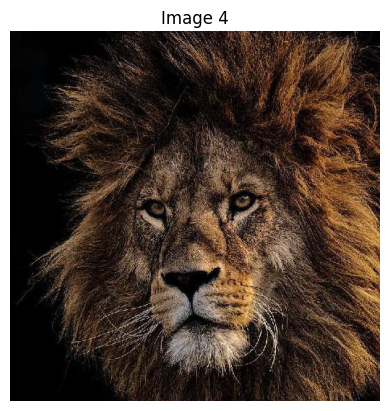

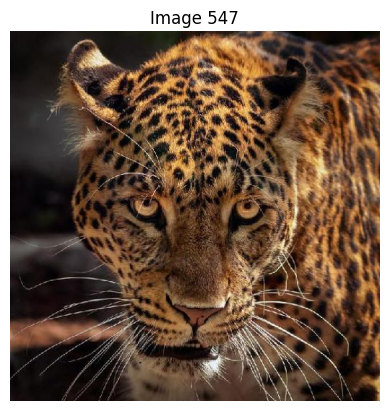

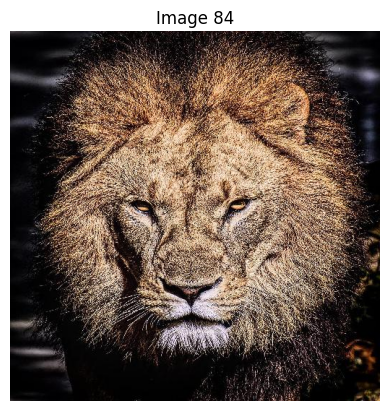

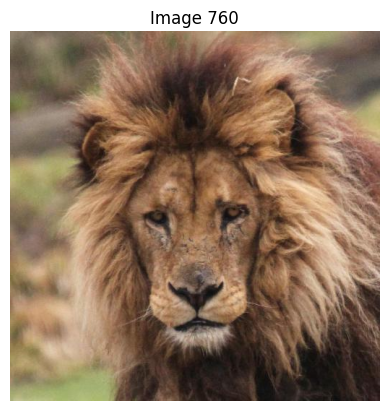

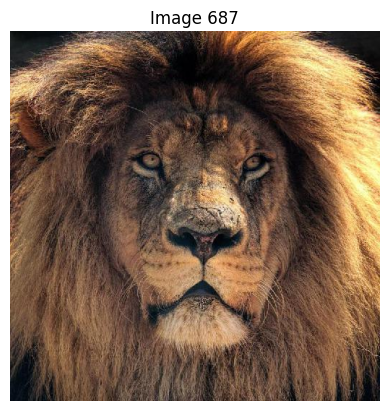

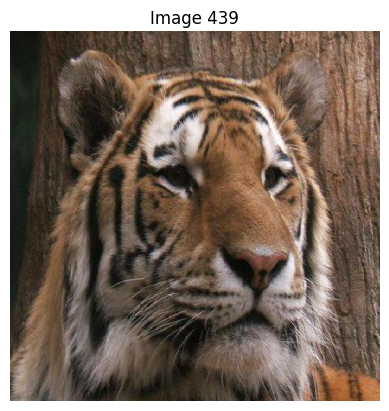

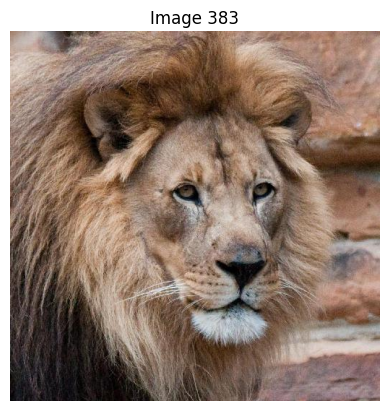

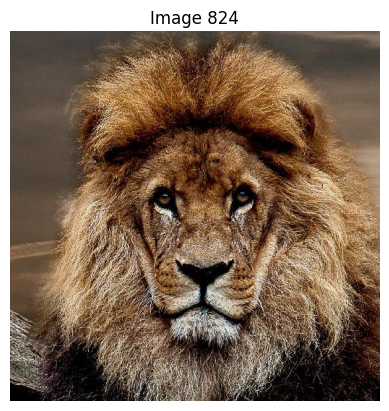

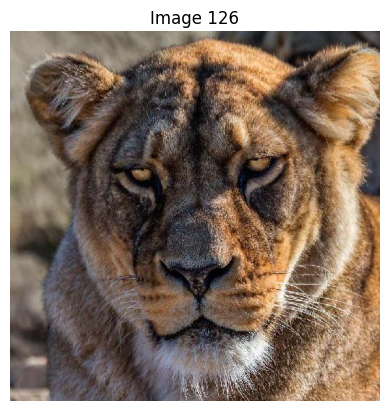

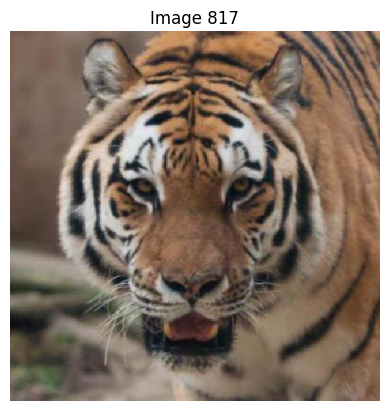

KeyboardInterrupt: 

In [45]:
for number in res:
    file_path = "../../test/dataset/" + str(number) + ".jpg"
    img = mpimg.imread(file_path)
    plt.imshow(img)
    plt.title(f"Image {number}")
    plt.axis('off')
    plt.show()